# Data analysis

Please, make sure that data is copied to ./data folder so that the structure from the root folder is the following:

```
codes
│   README.md   
│
└───data
│   │   eda.ipynb
│   │
│   └───data
│       │   x_test.txt
│       │   x_train.txt
│       │   y_train.txt
│   
└───...
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

X = pd.read_table('./data/x_train.txt', header=None, delimiter=' ')
y = pd.read_table('./data/y_train.txt', header=None)

X_test = pd.read_table('./data/x_test.txt', header=None, delimiter=' ')

Check for the empty values in the train and test

In [4]:
print(f'Empty values in Train dataset: {X.isna().any().any()}')
print(f'Empty values in Test dataset: {X_test.isna().any().any()}')

Empty values in Train dataset: False
Empty values in Test dataset: False


Check balance of the targat variable in the training set. 

The target variable is almost perfectly balanced.

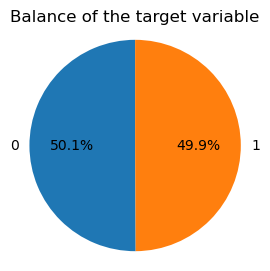

In [22]:
target_counts = y.value_counts()

# Plot a pie chart
plt.figure(figsize=(3, 3))
plt.pie(target_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
plt.title('Balance of the target variable')
plt.axis('equal')
plt.show()

Feature selection

In [5]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1
clf = LogisticRegression()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X, y)


pred = np.where(rfecv.get_support())[0]
print(f'Number of features to consider: {pred.shape[0]}')
pred

Number of features to consider: 49


array([200, 203, 204, 206, 210, 214, 215, 218, 220, 225, 227, 228, 240,
       249, 250, 252, 253, 259, 266, 273, 277, 281, 283, 285, 288, 291,
       296, 303, 306, 308, 309, 316, 317, 321, 322, 323, 324, 327, 328,
       335, 339, 351, 356, 357, 360, 363, 369, 380, 387], dtype=int64)

In [2]:
# np.save('features.npy', pred) # Not a final list of feature, but a place to start with
features = np.load('boruta_features.npy')

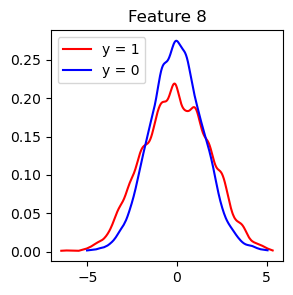

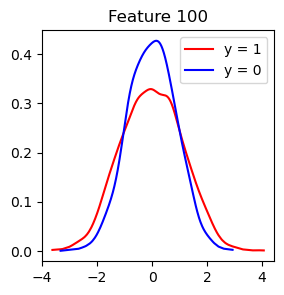

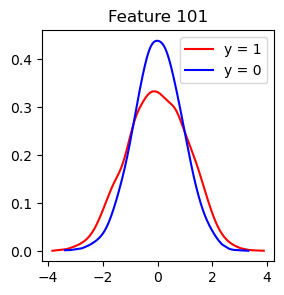

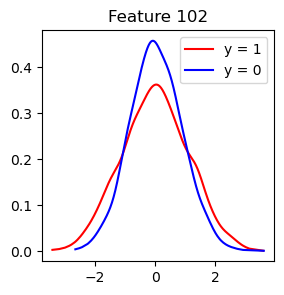

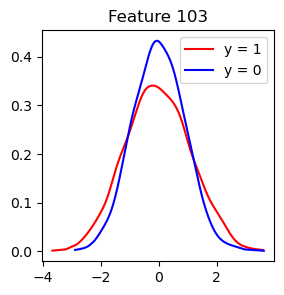

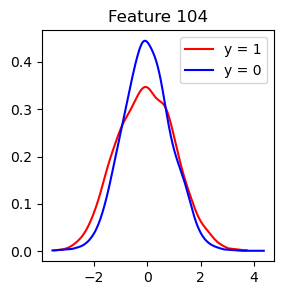

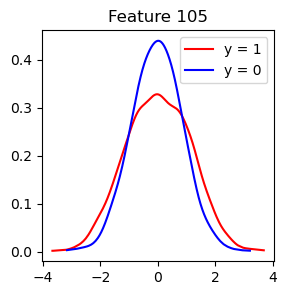

In [7]:
# Kernel density estimation
from sklearn.neighbors import KernelDensity

def kernal_density_pdf(X, kernel='gaussian', bandwidth=1.0):
  kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(X.reshape(-1, 1))
  return np.exp(kde.score_samples(X.reshape(-1, 1)))

X1 = X.iloc[y.index[y[0] == 1]]
X0 = X.iloc[y.index[y[0] == 0]]

for i in features:
  sorted1 = X1[i].sort_values()
  sorted0 = X0[i].sort_values()
  kde_y1 = kernal_density_pdf(sorted1.values, kernel='gaussian', bandwidth='silverman')
  kde_y0 = kernal_density_pdf(sorted0.values, kernel='gaussian', bandwidth='silverman')
  plt.figure(figsize=(3, 3))
  plt.plot(sorted1, kde_y1, color='red', label='y = 1');
  plt.plot(sorted0, kde_y0, color='blue', label='y = 0');
  plt.title(f'Feature {i}')
  plt.legend()
  plt.show()

# Boruta feature selection

In [7]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

feat_selector = BorutaPy(
    verbose=1,
    estimator=model,
    n_estimators='auto',
    max_iter=10  # number of iterations to perform
)
feat_selector.fit(np.array(X), np.array(y))

# feat_selector.support_

pred = np.where(feat_selector.support_)[0]
print(f'Number of features to consider: {pred.shape[0]}')
np.save('boruta_features.npy', pred)
pred

array([  8, 100, 101, 102, 103, 104, 105], dtype=int64)

# Lasso feature selection

In [2]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
model = SelectFromModel(lasso, prefit=True)
pred = np.where(model.get_support())[0]
print(f'Number of features to consider: {pred.shape[0]}')
np.save('lasso_features.npy', pred)
pred

Number of features to consider: 1


array([403], dtype=int64)

# Summary

Linear models are not well suted for the dataset both for feature selection and for the prediction. All non-linear feature selection methods suggest the following features to consider:
* [100, 101, 102, 103, 104, 105]